In [49]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import copy
import scipy.stats
from scipy.stats import shapiro
from scipy.stats import kruskal
import tabulate
from tabulate import tabulate
import numpy as np
from sklearn.cluster import KMeans
from scipy import stats

# Research Question

How does combine performance affect the draft stock of an NFL athlete?

# Hypothesis

The better that NFL draftee's combine performance will cause them to be drafted higher in relation to other players of the same position. 

# Data Preprocessing

To identify this problem two different data sets were used. The first data set was used to highlight the combine performance of players. This data set highlighted metrics such as their 40 yard dash time, height, weight, vertical, bench press, 3 cone drill time, shuttle cone drill time. This includes combine performances for every single player that attended the combine from the years 2000 - 2022. 

The second data set was used to identify the player's draft position. This was not stated in the original data set, so by combining the two data sets together we are able to create a data set that has all combine metrics as well as draft position. 



In [50]:
csv_files = glob.glob('./combine-data/*.csv')
draft_df = pd.read_csv('./draft-data/nfl_draft_prospects.csv')
comb_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    comb_df = pd.concat([comb_df, df])

select_df = draft_df[['draft_year', 'player_name', 'school', 'pick', 'overall', 'round']]
select_df.head()

,draft_year,player_name,school,pick,overall,round
0,1967,Bubba Smith,Michigan State,1.0,1.0,1.0
1,1967,Clinton Jones,Michigan State,2.0,2.0,1.0
2,1967,Steve Spurrier,Florida,3.0,3.0,1.0
3,1967,Bob Griese,Purdue,4.0,4.0,1.0
4,1967,George Webster,Michigan State,5.0,5.0,1.0


In [51]:
merged_df = pd.merge(comb_df, select_df, left_on=['Player', 'School'], right_on=['player_name', 'school'], how='inner')
merged_df = merged_df.drop(['player_name', 'school'], axis=1)

In [52]:
comb_df.head(10)

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
0,John Abraham,OLB,South Carolina,6-4,252.0,4.55,NaN,NaN,NaN,NaN,NaN
1,Shaun Alexander,RB,Alabama,6-0,218.0,4.58,NaN,NaN,NaN,NaN,NaN
2,Darnell Alford,OT,Boston Col.,6-4,334.0,5.56,25.0,23.0,94.0,8.48,4.98
3,Kyle Allamon,TE,Texas Tech,6-2,253.0,4.97,29.0,NaN,104.0,7.29,4.49
4,Rashard Anderson,CB,Jackson State,6-2,206.0,4.55,34.0,NaN,123.0,7.18,4.15
5,Jake Arians,K,Ala-Birmingham,5-10,202.0,NaN,NaN,NaN,NaN,NaN,NaN
6,LaVar Arrington,OLB,Penn State,6-3,250.0,4.53,NaN,NaN,NaN,NaN,NaN
7,Corey Atkins,OLB,South Carolina,6-0,237.0,4.72,31.0,21.0,112.0,7.96,4.39
8,Kyle Atteberry,K,Baylor,6-0,167.0,NaN,NaN,NaN,NaN,NaN,NaN
9,Reggie Austin,CB,Wake Forest,5-9,175.0,4.44,35.0,17.0,119.0,7.03,4.14


In [53]:
merged_df.head(10)

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,draft_year,pick,overall,round
0,John Abraham,OLB,South Carolina,6-4,252.0,4.55,NaN,NaN,NaN,NaN,NaN,2000,13.0,13.0,1.0
1,Shaun Alexander,RB,Alabama,6-0,218.0,4.58,NaN,NaN,NaN,NaN,NaN,2000,19.0,19.0,1.0
2,Rashard Anderson,CB,Jackson State,6-2,206.0,4.55,34.0,NaN,123.0,7.18,4.15,2000,23.0,23.0,1.0
3,LaVar Arrington,OLB,Penn State,6-3,250.0,4.53,NaN,NaN,NaN,NaN,NaN,2000,2.0,2.0,1.0
4,Reggie Austin,CB,Wake Forest,5-9,175.0,4.44,35.0,17.0,119.0,7.03,4.14,2000,31.0,125.0,4.0
5,Mark Baniewicz,OT,Syracuse,6-6,312.0,5.34,28.0,20.0,96.0,7.72,4.73,2000,41.0,247.0,7.0
6,Rashidi Barnes,S,Colorado,6-0,208.0,4.62,35.0,10.0,114.0,6.92,4.32,2000,19.0,225.0,7.0
7,David Barrett,CB,Arkansas,5-10,199.0,4.44,37.5,16.0,116.0,6.81,4.04,2000,8.0,102.0,4.0
8,William Bartee,CB,Oklahoma,6-1,192.0,4.43,38.5,NaN,124.0,6.70,3.99,2000,23.0,54.0,2.0
9,Robert Bean,CB,Mississippi State,5-11,178.0,4.50,34.5,NaN,122.0,6.87,4.20,2000,4.0,133.0,5.0


## Handling Missing Values

Missing values are something that is a little tricky with this dataset. There are a lot of missing values, but it is not as easy as filling them in or dropping the ones that have missing data. There is supposed to be missing values, that is because some positions don't do certain drills. For instance quarterbacks do not participate in the bench press drill. So this is going to have to be very position specific. 

There is also variables such as the height that need to be turned into an actual numeric representation and not the string representation that it is now.

In [54]:
def convert_height(height):
    '''
    This method converts the parameter height into two decimal places. 
    This is neccesary because the given value is of type string and a numerical 
    representation for it is needed.
    :param height: 
    :return: 
    '''
    if height:
        feet = int(str(height)[0:1])
        inches_str = str(height)[2:]
        if inches_str:  
            inches = int(inches_str)
            return str(feet + round(inches / 12, 2))
    return None

merged_df = merged_df.dropna(subset=['Ht'])
merged_df['Ht'] = merged_df.Ht.apply(lambda x: convert_height(x))

In [55]:
# All the positions possible
positions = ['CB', 'OT', 'S', 'OG', 'ILB', 'DE', 'RB', 'FB', 'TE', 'OLB', 'DT',
       'C', 'WR', 'QB', 'LS', 'EDGE', 'LB', 'OL', 'DL', 'DB']
filtered_positions = ['CB', 'OT', 'S', 'OG', 'ILB', 'DE', 'RB', 'FB', 'TE', 'OLB', 'DT',
       'C', 'WR', 'EDGE', 'LB', 'OL', 'DL', 'DB']
# All of the drills being performed
drills = ['40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']

drill_count_per_position = {'Pos' : [], '40yd' : [], 'Vertical' : [], 'Bench' : [], 'Broad Jump' : [], '3Cone' : [], 'Shuttle' : []}

To get an idea of what positions do what drills we are count how drills are done for each position. 

In [56]:
for position in positions:
    drill_count_per_position['Pos'].append(position)
    for drill in drills:
        count = merged_df[merged_df['Pos'] == position][drill].dropna().size
        drill_count_per_position[drill].append(count)

In [57]:
drill_count_per_position_df = pd.DataFrame(drill_count_per_position)
drill_count_per_position_df.head(20)

,Pos,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
0,CB,509,420,411,421,323,331
1,OT,343,290,289,286,268,273
2,S,351,304,306,303,221,222
3,OG,230,188,195,184,174,180
4,ILB,180,148,149,146,114,119
5,DE,347,277,271,274,242,248
6,RB,391,332,314,325,234,233
7,FB,74,65,61,65,61,61
8,TE,255,213,213,207,183,183
9,OLB,333,273,261,278,235,240


This gives a pretty good idea of what positions partake in what drills. For instance, QB's do not seem to partake in the bench press. But this also shows how some positions do not have many players. For instance LS (Long Snapper) has next to no data associated with it. But for the drills we are going to administer on, we need to make sure that the players have participated in ALL of the drills. Not just some. So lets see how many players per each position have participated in all of the drills...

In [58]:
count_per_pos = {}
for position in positions:
    temp = merged_df[merged_df['Pos'] == position].dropna()
    count_per_pos[position] = temp.size

print(count_per_pos)

{'CB': 3300, 'OT': 2910, 'S': 2295, 'OG': 1935, 'ILB': 1095, 'DE': 2670, 'RB': 2310, 'FB': 630, 'TE': 2010, 'OLB': 2580, 'DT': 2280, 'C': 975, 'WR': 2610, 'QB': 30, 'LS': 15, 'EDGE': 180, 'LB': 300, 'OL': 555, 'DL': 405, 'DB': 240}


There seems to be a sufficent amount of data for each position. However, there are positions that do not make sense to analyze based on combine performance alone. One of those positions is Quarterback. The combine drills in this dataset does not account for how well they throw, which of course is the most important skill for a QB. Another is a Long Snapper, they just do not have enough data to use in this dataset. Besides those two positions every other position should be okay to do.  

In [59]:
# Removing those positions now
merged_df = merged_df[(merged_df['Pos'] != 'QB') & (merged_df['Pos'] != 'LS')]
merged_df = merged_df.dropna()

Now lets grab only the necessary data. We are not going to need to know which pick they were, their name, the school they went to. We are not trying to predict any of those variables, nor are we trying to predict on any of those variables.

In [60]:
cols_to_exclude = ['Player', 'draft_year', 'overall', 'School', 'pick']
final_combine_data = merged_df.drop(cols_to_exclude, axis=1)
final_combine_data.head()

,Pos,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,round
4,CB,5.75,175.0,4.44,35.0,17.0,119.0,7.03,4.14,4.0
5,OT,6.5,312.0,5.34,28.0,20.0,96.0,7.72,4.73,7.0
6,S,6.0,208.0,4.62,35.0,10.0,114.0,6.92,4.32,7.0
7,CB,5.83,199.0,4.44,37.5,16.0,116.0,6.81,4.04,4.0
11,S,6.08,207.0,4.62,39.5,15.0,119.0,6.48,4.29,2.0


## Handling Class Imbalances

We have seven rounds of course, but we do not want there to be more players in certain rounds or that might bias the results. Let's see if there are severe class imbalances going on, if so we need to handle them accordingly.

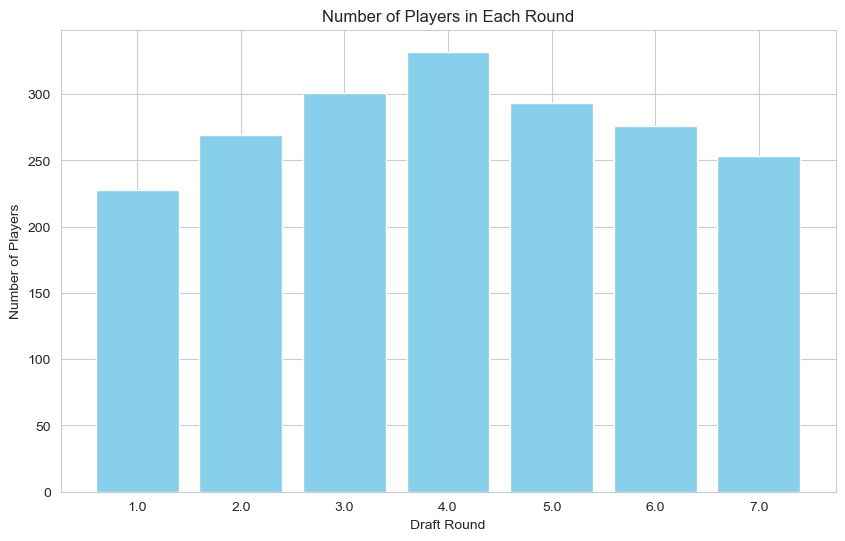

In [61]:
round_counts = final_combine_data['round'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(round_counts.index.astype(str), round_counts.values, color='skyblue')
plt.xlabel('Draft Round')
plt.ylabel('Number of Players')
plt.title('Number of Players in Each Round')
plt.show()

Some rounds clearly do have more players than other rounds. But there is another imbalance we have to worry about, that being positional imbalances. Some rounds may have more players in a certain position than other rounds do. For instance, if there are 20 WR's in round 1 and only 4 in round 7, the model might bias towards round 1. 

In [62]:
def get_position_count_per_round(pos):
    '''
    This method will return a list corresponding to the number of players per position for that round. 
    '''
    result = []
    for round in range(1,8):
        for position in [pos]:
            result.append(final_combine_data[(final_combine_data['round'] == round) & (final_combine_data['Pos'] == position)].shape[0])
    return result

Now we can rebalance all of the rounds to have the same number of players per position. We want to only include positions that have at least ten players in each round. And then make sure that there is the same number of players in each round per position. At the end we should have seven rounds, all of equal size.

In [63]:
THRESHOLD = 10 # minimum number of players per round
balanced_final_combine_data = pd.DataFrame()

for round in range(1,8):
    for position in final_combine_data['Pos'].unique():
        min_player_count = np.min(get_position_count_per_round(position))
        if min_player_count >= THRESHOLD:
            df = final_combine_data[(final_combine_data['round'] == round) & (final_combine_data['Pos'] == position)]
            random_samples = df.sample(n=min_player_count)
            balanced_final_combine_data = pd.concat([balanced_final_combine_data, random_samples], ignore_index=True)

final_combine_data = balanced_final_combine_data

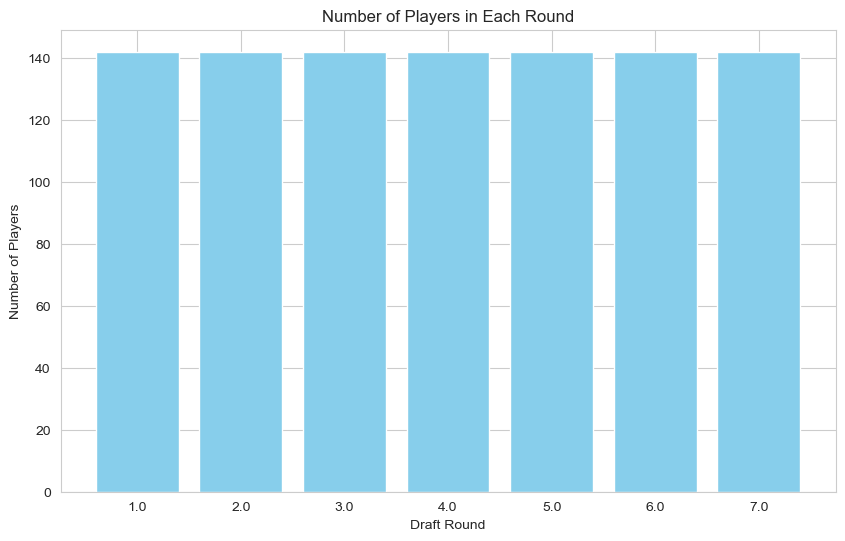

In [64]:
round_counts = final_combine_data['round'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(round_counts.index.astype(str), round_counts.values, color='skyblue')
plt.xlabel('Draft Round')
plt.ylabel('Number of Players')
plt.title('Number of Players in Each Round')
plt.show()

And now we need to make the position variable categorical, so by using one hot encoding we can do that

In [65]:
final_combine_data = pd.get_dummies(final_combine_data, columns=['Pos'])
final_combine_data.head()

,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,round,Pos_CB,Pos_DE,Pos_DT,Pos_OG,Pos_OLB,Pos_OT,Pos_RB,Pos_S,Pos_TE,Pos_WR
0,5.92,193.0,4.52,35.0,18.0,125.0,6.94,4.34,1.0,1,0,0,0,0,0,0,0,0,0
1,6.0,204.0,4.51,33.0,15.0,124.0,6.59,4.08,1.0,1,0,0,0,0,0,0,0,0,0
2,6.17,211.0,4.42,36.0,24.0,123.0,6.93,4.06,1.0,1,0,0,0,0,0,0,0,0,0
3,5.92,193.0,4.39,37.5,15.0,125.0,6.50,4.07,1.0,1,0,0,0,0,0,0,0,0,0
4,5.92,199.0,4.38,39.0,11.0,127.0,6.87,4.32,1.0,1,0,0,0,0,0,0,0,0,0


# Visualizing the Data

### 40-Yard Dash

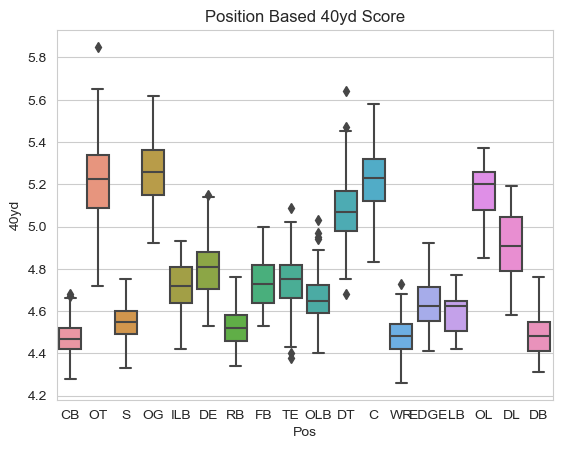

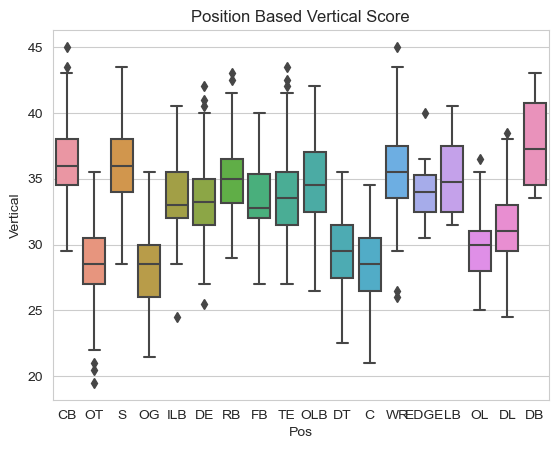

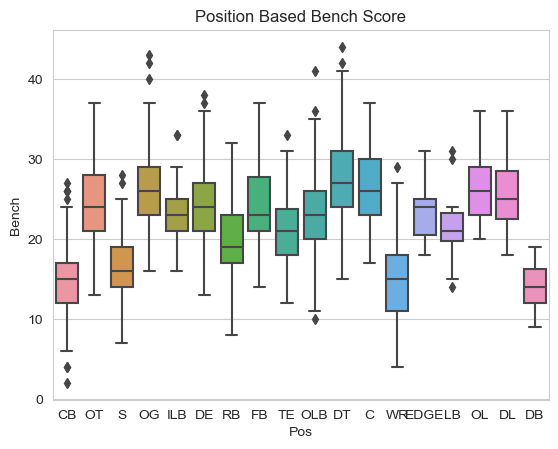

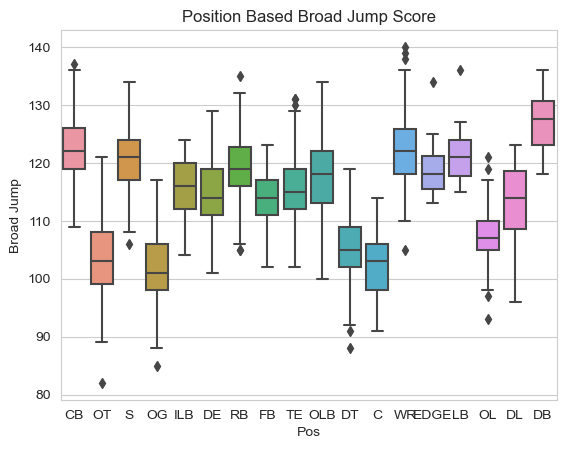

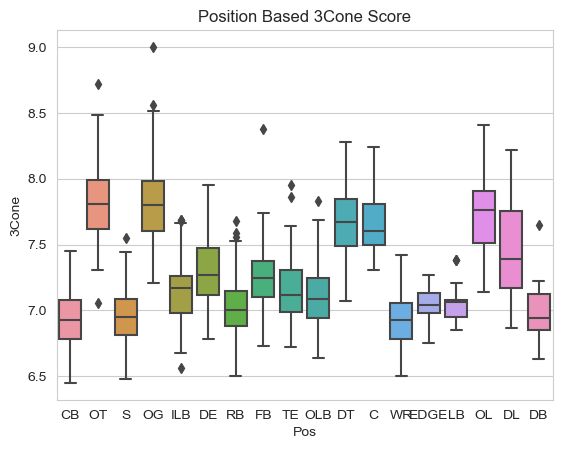

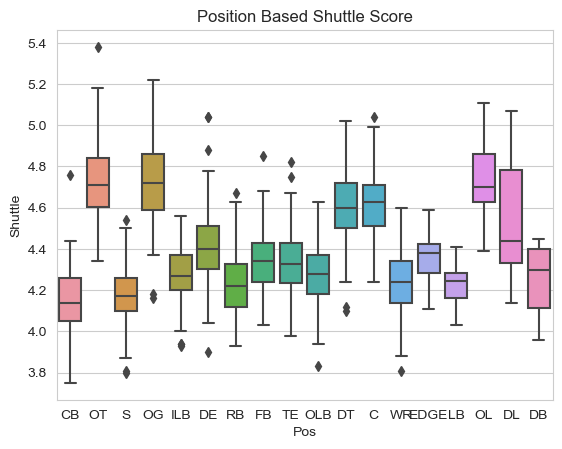

<Figure size 640x480 with 0 Axes>

In [66]:
forty_dash = merged_df.dropna(subset=['40yd'])
# sns.scatterplot(data=merged_df, x='overall', y='40yd')
# print(forty_dash['Pos'].unique())
for drill in drills:
    drill_df = merged_df.dropna(subset=[drill])
    sns.boxplot(data=drill_df, x='Pos', y=drill)
    plt.title("Position Based " + drill + " Score")
    plt.show()
    plt.clf()

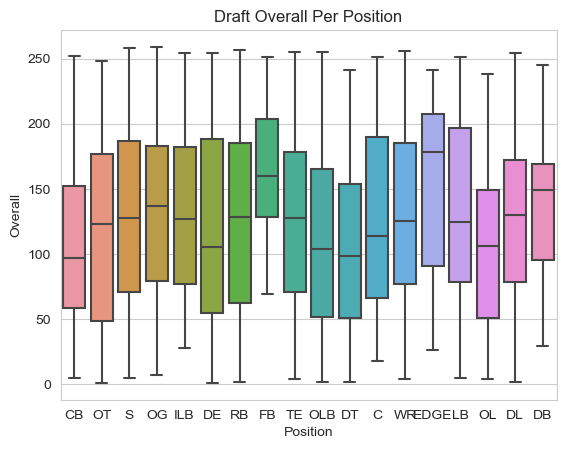

In [67]:
sns.boxplot(data=merged_df, x='Pos', y='overall')
plt.title("Draft Overall Per Position")
plt.xlabel('Position')
plt.ylabel('Overall')
plt.show()

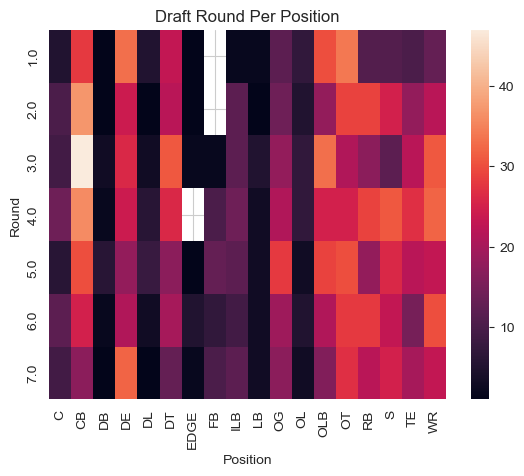

In [68]:
contingency_table = pd.pivot_table(merged_df, values='overall', index='round', columns='Pos', aggfunc='count')


sns.heatmap(contingency_table)
plt.title("Draft Round Per Position")
plt.xlabel('Position')
plt.ylabel('Round')
plt.show()

### See if Data is normally distributed

In [69]:
alpha = 0.05
for drill in drills:
    drill_df = merged_df.dropna(subset=[drill])
    for pos in filtered_positions:
        pos_df = drill_df[drill_df['Pos'] == pos]
        statistic, p_value = shapiro(pos_df[drill])
        if p_value < alpha:
            print("Position: " + pos + " at Drill: " + drill + " is NOT normally distributed")

Position: OL at Drill: 40yd is NOT normally distributed
Position: RB at Drill: Vertical is NOT normally distributed
Position: LB at Drill: Vertical is NOT normally distributed
Position: DB at Drill: Vertical is NOT normally distributed
Position: CB at Drill: Bench is NOT normally distributed
Position: ILB at Drill: Bench is NOT normally distributed
Position: DE at Drill: Bench is NOT normally distributed
Position: FB at Drill: Bench is NOT normally distributed
Position: TE at Drill: Broad Jump is NOT normally distributed
Position: LB at Drill: Broad Jump is NOT normally distributed
Position: OG at Drill: 3Cone is NOT normally distributed
Position: RB at Drill: 3Cone is NOT normally distributed
Position: FB at Drill: 3Cone is NOT normally distributed
Position: TE at Drill: 3Cone is NOT normally distributed
Position: C at Drill: 3Cone is NOT normally distributed
Position: LB at Drill: 3Cone is NOT normally distributed
Position: DB at Drill: 3Cone is NOT normally distributed
Position: CB 

### Many Positions have non uniform distributions of drills
It is wise to Use Kruskal-Wallis test knowing this. Anova testing requires for data to be uniform

In [70]:
kruskal_tests = []
kruskal_head = ['Drill', 'Stat', 'P Value']
for drill in drills:
    drill_df = merged_df.dropna(subset=[drill])
    samples_by_group = []
    for pos in positions:
        pos_drill_df = drill_df[drill_df['Pos'] == pos]
        if len(pos_drill_df[drill]) != 0:
            samples_by_group.append(pos_drill_df[drill].tolist())
    stat, p = kruskal(*samples_by_group)
    kruskal_tests.append([drill, stat, p])
print(tabulate(kruskal_tests, headers=kruskal_head, tablefmt="grid"))

+------------+----------+--------------+
| Drill      |     Stat |      P Value |
+============+==========+==============+
| 40yd       | 1615.38  | 0            |
+------------+----------+--------------+
| Vertical   | 1008.37  | 1.45654e-203 |
+------------+----------+--------------+
| Bench      |  987.793 | 3.67512e-199 |
+------------+----------+--------------+
| Broad Jump | 1213.61  | 1.58409e-247 |
+------------+----------+--------------+
| 3Cone      | 1273.55  | 2.18357e-260 |
+------------+----------+--------------+
| Shuttle    | 1212.51  | 2.7219e-247  |
+------------+----------+--------------+


In [71]:
kruskal_tests = []
kruskal_head = ['Drill', 'Stat', 'P Value']
for drill in drills:
    drill_df = merged_df.dropna(subset=[drill])
    samples_by_group = []
    for value in set(drill_df[drill]):
        mask = drill_df[drill] == value
        samples_by_group.append(drill_df['Pos'][mask]) 
    stat, p = kruskal(*samples_by_group)
    kruskal_tests.append([drill, stat, p])
print(tabulate(kruskal_tests, headers=kruskal_head, tablefmt="grid"))

+------------+----------+-------------+
| Drill      |     Stat |     P Value |
+============+==========+=============+
| 40yd       | 231.91   | 4.24483e-07 |
+------------+----------+-------------+
| Vertical   |  51.0679 | 0.354038    |
+------------+----------+-------------+
| Bench      | 122.673  | 2.5126e-10  |
+------------+----------+-------------+
| Broad Jump | 113.332  | 4.23677e-06 |
+------------+----------+-------------+
| 3Cone      | 244.386  | 0.00823835  |
+------------+----------+-------------+
| Shuttle    | 194.619  | 0.000731051 |
+------------+----------+-------------+


### Analyzing P-Values of Kruskal-Wallis Test
Since all the p-values for each drill using the Kruskal-Wallis test are less than the level of significance (0.05), the null hypothesis for each drill is rejected. So, for each drill, the median values for each position based on drill are not equal 

# KMEANS

In [72]:
X = final_combine_data[drills]
kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(X)
# print(kmeans.cluster_centers_)
print(np.unique(kmeans.labels_))
label_df = final_combine_data.copy()
label_df['label'] = np.array(kmeans.labels_)
label_df.head()

[0 1 2 3 4 5 6]


C:\Users\mcdonaldp\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,round,Pos_CB,Pos_DE,Pos_DT,Pos_OG,Pos_OLB,Pos_OT,Pos_RB,Pos_S,Pos_TE,Pos_WR,label
0,5.92,193.0,4.52,35.0,18.0,125.0,6.94,4.34,1.0,1,0,0,0,0,0,0,0,0,0,6
1,6.0,204.0,4.51,33.0,15.0,124.0,6.59,4.08,1.0,1,0,0,0,0,0,0,0,0,0,1
2,6.17,211.0,4.42,36.0,24.0,123.0,6.93,4.06,1.0,1,0,0,0,0,0,0,0,0,0,4
3,5.92,193.0,4.39,37.5,15.0,125.0,6.50,4.07,1.0,1,0,0,0,0,0,0,0,0,0,6
4,5.92,199.0,4.38,39.0,11.0,127.0,6.87,4.32,1.0,1,0,0,0,0,0,0,0,0,0,6


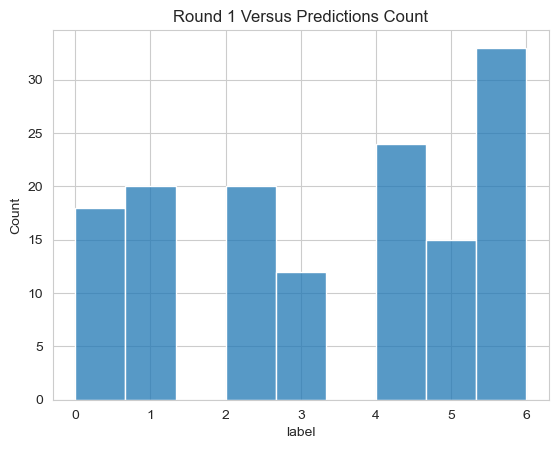

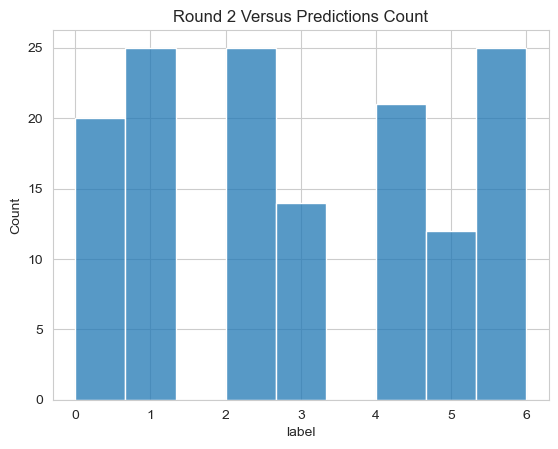

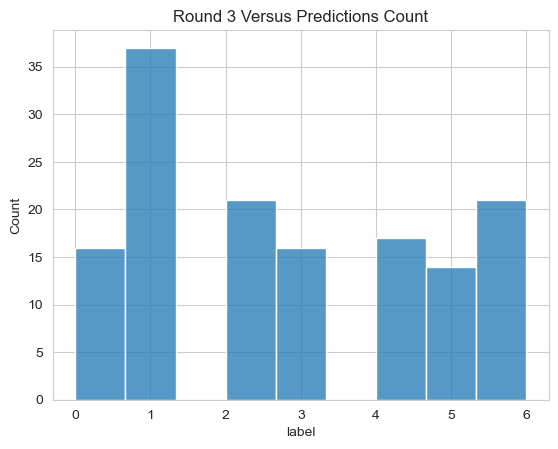

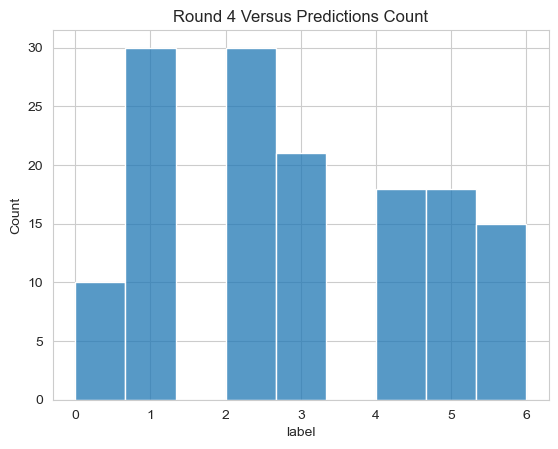

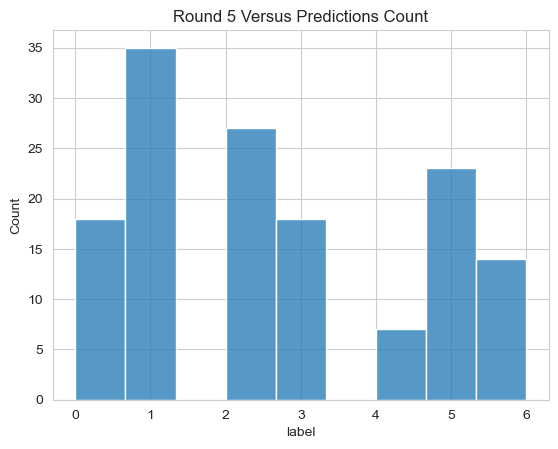

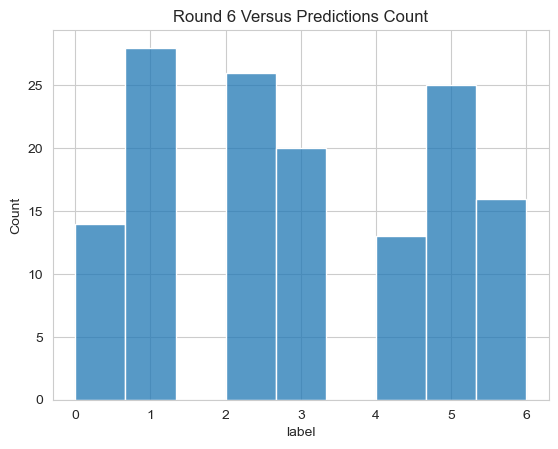

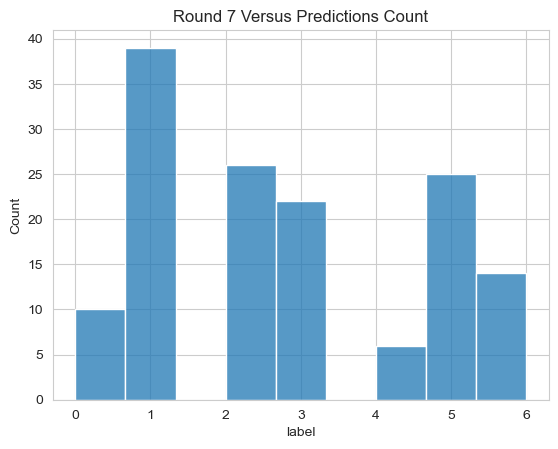

<Figure size 640x480 with 0 Axes>

In [73]:
for draft_round in range(7): 
    round_label_df = label_df[label_df["round"] == draft_round + 1]
    sns.histplot(data=round_label_df, x="label")
    plt.title("Round " + str(draft_round + 1) + " Versus Predictions Count")
    plt.show()
    plt.clf()

# Pearson's Correlation

In [74]:
pears_list = []
for pos in filtered_positions:
    pos_df = merged_df[merged_df["Pos"] == pos]
    for drill in drills:
        pears, p = stats.pearsonr(x=pos_df[drill], y=pos_df['overall'])
        pears_list.append([str(pos), drill, pears, p])
      
pears_header = ["Position", "Drill", "Pearson Coefficient", "P value"]
# print(tabulate(pears_list, headers=pears_header, tablefmt="grid"))
pears_df = pd.DataFrame(pears_list)
pears_df.head(108)

,0,1,2,3
0,CB,40yd,0.321129,0.000001
1,CB,Vertical,-0.148725,0.027408
2,CB,Bench,-0.100245,0.138302
3,CB,Broad Jump,-0.233329,0.000484
4,CB,3Cone,0.239351,0.000341
...,...,...,...,...
103,DB,Vertical,0.030043,0.912055
104,DB,Bench,0.101532,0.708291
105,DB,Broad Jump,0.002045,0.994002
106,DB,3Cone,0.266228,0.318925


# Different Scales Pearsons
When using the pearson's calculation above, the overall coefficient if the statistic that is desired (given that the p-value checks out). If the coefficient is positive, then that means that the slope is positive. if the coefficient is negative, then that means the slope if negative. Values closer to -1 and 1 mean the data is more close together. 

This project is attempting to claim that "better" scores will yield a higher draft position. So, performing a pearson's correlation of the overall pick against the drill for each position will give a good idea on how related the two attributes are. Now, each coefficient will tell something different, it is just necessary to understand it. 

The pearson's correlation uses both x and y values as input with the x variable being the drill and the y variable being the overall pick number. These x and y values are can then be placed on a graph from smallest to largest on each axis. The slope of the regression line from the data points is then calculated from the graph. 

It is important to note that each drill has different definitions of "successful". For example, a "good" score for the bench press is getting as many repetitions as possible. So, in this case the highest number is the best number. With the 40yd dash, the faster time indicates a "good score". The issue comes into play when placing these values on a graph because the "good" scores are on the opposite side of the graph. So in the case of the bench press, we proposed that more reps indicates a lower pick, but for the 40yd dash, the lower the score the lower the pick. What this means is that each drill has to be split and interpreted differently based on the score.

['40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']
The bench press, broad jump, and vertical jump are all drills where a higher score will yield a lower overall draft pick. This means a negative pearson's coefficient is preferred to support the hypothesis.

The 40yd dash, 3cone, and shuttle are all speed drills in the lower number is preferred for a lower overall draft pick. This means a positive pearson's coefficient is preferred to support the hypothesis.


# Pearson's Conclusions
The data varies between positional groups, but it appears that there is indeed some statistically significant correlations in the data. This is especially true in the 40yd dash drill. For each position, this has the most correlation data. When considering the context of the NFL, this drill is widely considered to be the most important determinant in one's draft stock, so this makes sense. The coefficients for each drill are typically smaller, but they are majorly what is expected to be seen in terms of positivity or negativity. This means that while the correlation is still small, it is statistically significant.

In [75]:
## DO NOT DELETE CODE. VERY IMPORTANT FOR OVERALL RAS SCORE LATER


# sns.scatterplot(data=forty_dash[forty_dash['Pos'] == pos], x='overall', y='40yd')
# sns.boxplot(data=forty_dash, x='Pos', y='40yd')
# plt.title(pos + " 40yd Dash Times")
# plt.show()
# plt.clf()